In [20]:
data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])
# 查看数据集的列名
print(data.columns)

Index(['Date',
       'Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)',
       'LNG 160K CBM Spot Rate'],
      dtype='object')


C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\1941240535.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])


C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\3427120944.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])
C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\3427120944.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a sin

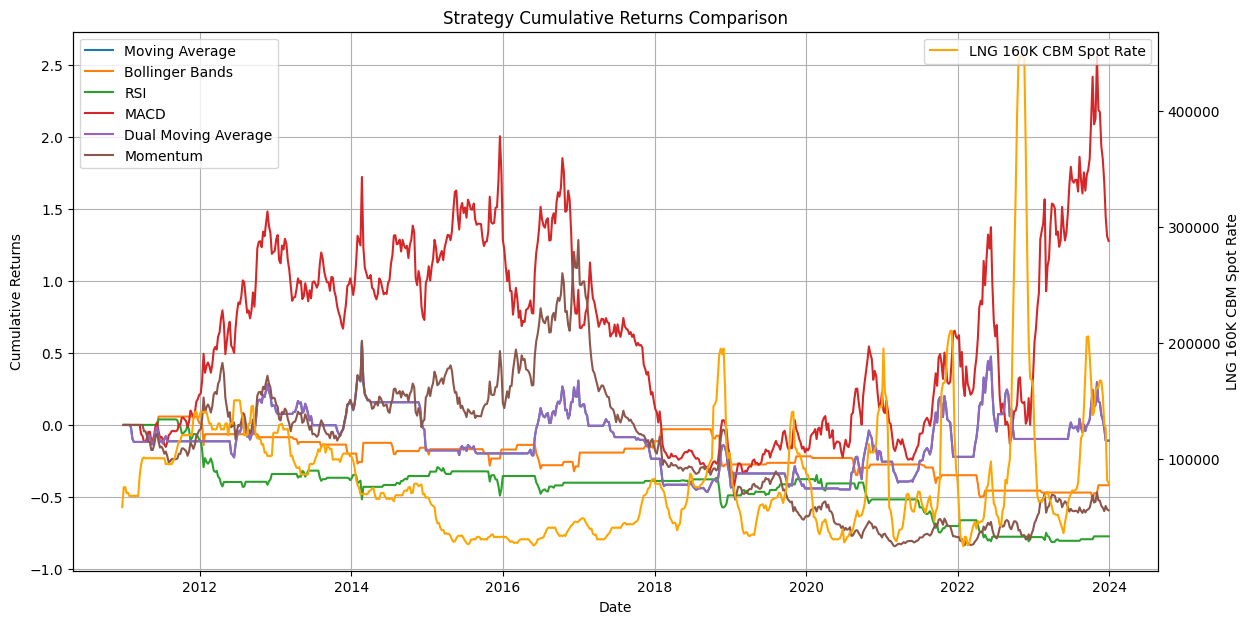

                    Total Return Annualized Return Sharpe Ratio Max Drawdown
Moving Average         -0.108873         -0.041818    -0.060697    -0.322656
Bollinger Bands        -0.418686         -0.182113     -0.53028    -0.298397
RSI                    -0.773587         -0.423321    -0.771682    -0.298397
MACD                    1.278046          0.356777     0.378129     -0.37973
Dual Moving Average    -0.108873         -0.041818    -0.060697    -0.322656
Momentum               -0.592485         -0.282992    -0.300211     -0.37973


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 读取数据
data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])

# 处理数据格式，将逗号去掉并转换为浮点数
data['LNG 160K CBM Spot Rate'] = data['LNG 160K CBM Spot Rate'].str.replace(',', '').astype(float)

# 将日期列转换为日期时间格式，并设置为索引
data.set_index('Date', inplace=True)

# 策略函数定义（保持不变）

def moving_average_strategy(data, short_window=5, long_window=20):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].rolling(window=long_window, min_periods=1).mean()
    signals['signal'][short_window:] = (signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:]) * 1.0
    signals['positions'] = signals['signal'].diff()
    return signals

def bollinger_band_strategy(data, window=20, num_std=2):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    rolling_mean = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].rolling(window=window, min_periods=1).mean()
    rolling_std = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].rolling(window=window, min_periods=1).std()
    signals['upper_band'] = rolling_mean + (rolling_std * num_std)
    signals['lower_band'] = rolling_mean - (rolling_std * num_std)
    signals['signal'][window:] = (data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'][window:] > signals['upper_band'][window:]) * -1.0 + \
                                 (data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'][window:] < signals['lower_band'][window:]) * 1.0
    signals['positions'] = signals['signal'].diff()
    return signals

def rsi_strategy(data, window=14, upper_threshold=70, lower_threshold=30):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    delta = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    signals['signal'][window:] = (rsi[window:] > upper_threshold) * -1.0 + (rsi[window:] < lower_threshold) * 1.0
    signals['positions'] = signals['signal'].diff()
    return signals

def macd_strategy(data, short_window=12, long_window=26, signal_window=9):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    short_ema = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].ewm(span=short_window, min_periods=1).mean()
    long_ema = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, min_periods=1).mean()
    signals['signal'][short_window:] = (macd[short_window:] > signal_line[short_window:]) * 1.0 + (macd[short_window:] < signal_line[short_window:]) * -1.0
    signals['positions'] = signals['signal'].diff()
    return signals

def dual_moving_average_strategy(data, short_window=5, long_window=20):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].rolling(window=long_window, min_periods=1).mean()
    signals['signal'][short_window:] = (signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:]) * 1.0
    signals['positions'] = signals['signal'].diff()
    return signals

# 动量策略
def momentum_strategy(data, window=14):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    signals['momentum'] = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].diff(window)
    signals['signal'][window:] = (signals['momentum'][window:] > 0) * 1.0 + (signals['momentum'][window:] < 0) * -1.0
    signals['positions'] = signals['signal'].diff()
    return signals

# 计算策略的累计收益率和其他指标
def calculate_performance(data, signals):
    positions = signals['signal'].shift()
    daily_returns = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].pct_change()
    strategy_returns = positions * daily_returns

    # 累计收益率
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    
    # 总收益率
    total_return = cumulative_returns.iloc[-1]
    
    # 年化收益率
    annualized_return = (1 + total_return)**(252/len(cumulative_returns)) - 1
    
    # 年化波动率
    annualized_volatility = strategy_returns.std() * np.sqrt(252)
    
    # 夏普比率
    sharpe_ratio = annualized_return / annualized_volatility
    
    # 最大回撤
    rolling_max = (1 + strategy_returns).cummax()
    daily_drawdown = (1 + strategy_returns)/rolling_max - 1
    max_drawdown = daily_drawdown.min()
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Cumulative Returns': cumulative_returns
    }

# 策略函数集合
strategies = {
    'Moving Average': moving_average_strategy,
    'Bollinger Bands': bollinger_band_strategy,
    'RSI': rsi_strategy,
    'MACD': macd_strategy,
    'Dual Moving Average': dual_moving_average_strategy,
    'Momentum': momentum_strategy
}

# 保存每个策略的性能指标
strategy_performance = {}

for name, strategy in strategies.items():
    signals = strategy(data)
    performance = calculate_performance(data, signals)
    strategy_performance[name] = performance

# 对LNG 160K CBM Spot Rate数据进行平滑处理
# data['LNG 160K CBM Spot Rate Smoothed'] = data['LNG 160K CBM Spot Rate'].rolling(window=4, min_periods=1).mean()

# 绘制所有策略的累计收益率比较，包括次坐标轴
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制累计收益率
for name, performance in strategy_performance.items():
    ax1.plot(performance['Cumulative Returns'], label=name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.set_title('Strategy Cumulative Returns Comparison')
ax1.legend(loc='upper left')
ax1.grid(True)

# 创建次坐标轴并绘制LNG 160K CBM Spot Rate
ax2 = ax1.twinx()
ax2.plot(data['LNG 160K CBM Spot Rate'], color='orange', label='LNG 160K CBM Spot Rate')
ax2.set_ylabel('LNG 160K CBM Spot Rate')
ax2.legend(loc='upper right')
ax2.grid(False)

plt.show()

# 输出每个策略的性能指标
performance_df = pd.DataFrame(strategy_performance).T
performance_df = performance_df[['Total Return', 'Annualized Return', 'Sharpe Ratio', 'Max Drawdown']]
print(performance_df)


发现MACD，Dual Moving Average和LNG 160K CBM Spot Rate都有明显的波动性（尤其是在2019年后），虽然这些波峰并不完全重合（峰值大小也不一致），但在数量和位置上有一定相似性。所以可以尝试利用LNG 160K CBM Spot Rate的波动来辅助MACD策略的信号生成或策略更换。

C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\4156673091.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])
C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\4156673091.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a sin

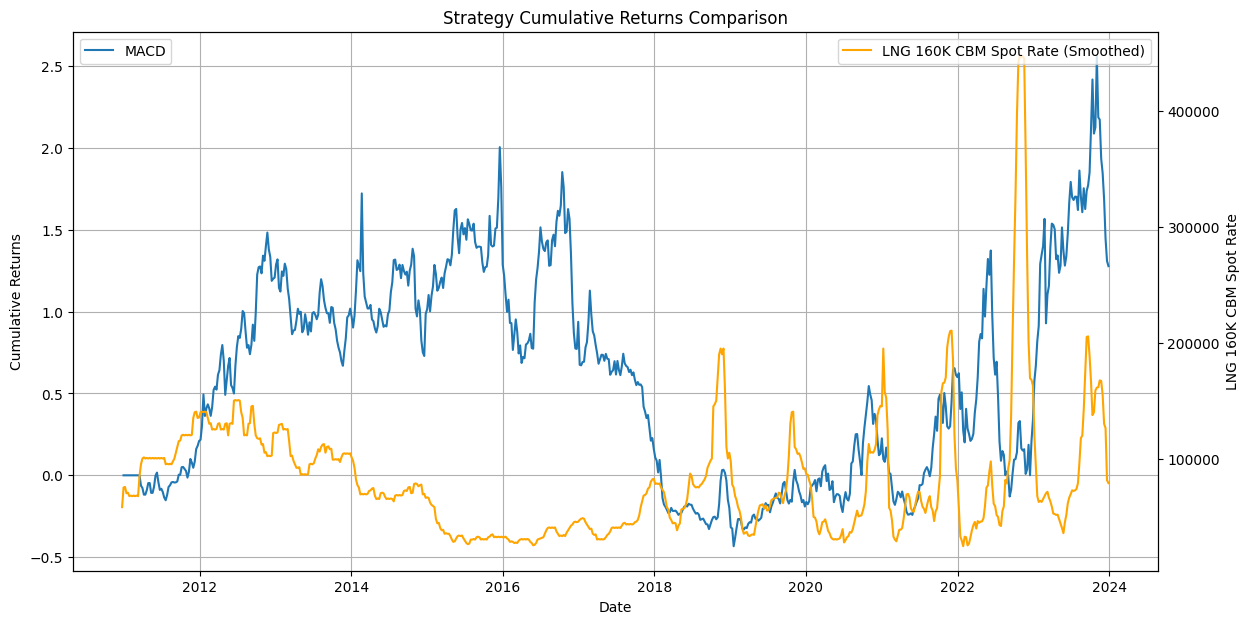

     Total Return Annualized Return Sharpe Ratio Max Drawdown
MACD     1.278046          0.356777     0.378129     -0.37973


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 读取数据
data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])

# 处理数据格式，将逗号去掉并转换为浮点数
data['LNG 160K CBM Spot Rate'] = data['LNG 160K CBM Spot Rate'].str.replace(',', '').astype(float)

# 将日期列转换为日期时间格式，并设置为索引
data.set_index('Date', inplace=True)

def macd_strategy(data, short_window=12, long_window=26, signal_window=9):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    short_ema = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].ewm(span=short_window, min_periods=1).mean()
    long_ema = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, min_periods=1).mean()
    signals['signal'][short_window:] = (macd[short_window:] > signal_line[short_window:]) * 1.0 + (macd[short_window:] < signal_line[short_window:]) * -1.0
    signals['positions'] = signals['signal'].diff()
    return signals



# 计算策略的累计收益率和其他指标
def calculate_performance(data, signals):
    positions = signals['signal'].shift()
    daily_returns = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].pct_change()
    strategy_returns = positions * daily_returns

    # 累计收益率
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    
    # 总收益率
    total_return = cumulative_returns.iloc[-1]
    
    # 年化收益率
    annualized_return = (1 + total_return)**(252/len(cumulative_returns)) - 1
    
    # 年化波动率
    annualized_volatility = strategy_returns.std() * np.sqrt(252)
    
    # 夏普比率
    sharpe_ratio = annualized_return / annualized_volatility
    
    # 最大回撤
    rolling_max = (1 + strategy_returns).cummax()
    daily_drawdown = (1 + strategy_returns)/rolling_max - 1
    max_drawdown = daily_drawdown.min()
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Cumulative Returns': cumulative_returns
    }

# 策略函数集合
strategies = {
    'MACD': macd_strategy,


}

# 保存每个策略的性能指标
strategy_performance = {}

for name, strategy in strategies.items():
    signals = strategy(data)
    performance = calculate_performance(data, signals)
    strategy_performance[name] = performance

# # 对LNG 160K CBM Spot Rate数据进行平滑处理
# data['LNG 160K CBM Spot Rate Smoothed'] = data['LNG 160K CBM Spot Rate'].rolling(window=4, min_periods=1).mean()

# 绘制所有策略的累计收益率比较，包括次坐标轴
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制累计收益率
for name, performance in strategy_performance.items():
    ax1.plot(performance['Cumulative Returns'], label=name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.set_title('Strategy Cumulative Returns Comparison')
ax1.legend(loc='upper left')
ax1.grid(True)

# 创建次坐标轴并绘制LNG 160K CBM Spot Rate
ax2 = ax1.twinx()
ax2.plot(data['LNG 160K CBM Spot Rate'], color='orange', label='LNG 160K CBM Spot Rate (Smoothed)')
ax2.set_ylabel('LNG 160K CBM Spot Rate')
ax2.legend(loc='upper right')
ax2.grid(False)

plt.show()

# 输出每个策略的性能指标
performance_df = pd.DataFrame(strategy_performance).T
performance_df = performance_df[['Total Return', 'Annualized Return', 'Sharpe Ratio', 'Max Drawdown']]
print(performance_df)

C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\1211389244.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])
C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\1211389244.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a sin

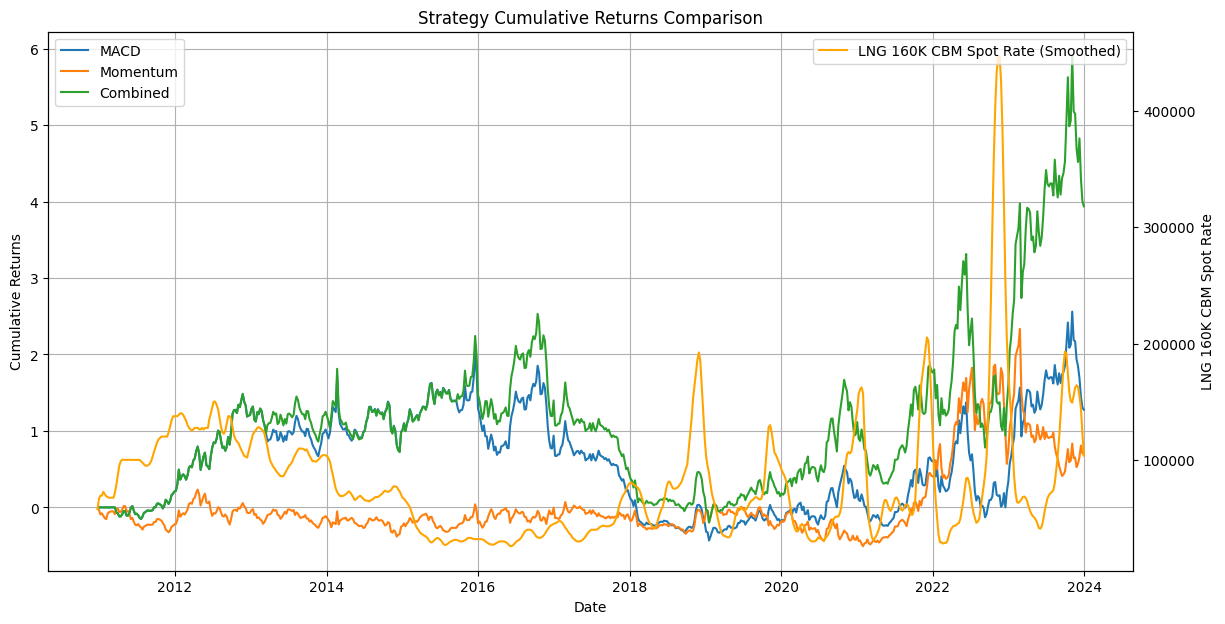

         Total Return Annualized Return Sharpe Ratio Max Drawdown
MACD         1.278046          0.356777     0.378129     -0.37973
Momentum     0.685372          0.213419     0.225358     -0.37973
Combined      3.93965          0.807489     0.856796     -0.37973


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])

# 处理数据格式，将逗号去掉并转换为浮点数
data['LNG 160K CBM Spot Rate'] = data['LNG 160K CBM Spot Rate'].str.replace(',', '').astype(float)

# 将日期列转换为日期时间格式，并设置为索引
data.set_index('Date', inplace=True)

# 定义市场状态
def define_market_state(data, window=4):
    data['LNG Rate Change'] = data['LNG 160K CBM Spot Rate'].pct_change().fillna(0)
    data['LNG MA'] = data['LNG 160K CBM Spot Rate'].rolling(window=window, min_periods=1).mean()
    data['Market State'] = np.where(data['LNG Rate Change'] > 0, 'up', 'down')
    
    # 检测波峰
    data['Peak'] = (data['LNG 160K CBM Spot Rate'] == data['LNG 160K CBM Spot Rate'].rolling(window=window, center=True).max())
    data['Peak'] = data['Peak'].shift().fillna(False)
    data['Post-Peak'] = (data['Peak'].shift() & (data['Market State'] == 'down')).fillna(False)
    
    return data

# MACD策略
def macd_strategy(data, short_window=12, long_window=26, signal_window=9):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    short_ema = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].ewm(span=short_window, min_periods=1).mean()
    long_ema = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, min_periods=1).mean()
    signals['signal'][short_window:] = (macd[short_window:] > signal_line[short_window:]) * 1.0 + (macd[short_window:] < signal_line[short_window:]) * -1.0
    signals['positions'] = signals['signal'].diff()
    return signals

# 动量策略
def momentum_strategy(data, window=4):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    momentum = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].pct_change(periods=window)
    signals['signal'] = np.where(momentum > 0, 1.0, -1.0)
    signals['positions'] = signals['signal'].diff()
    return signals

# 根据市场状态应用不同策略
def combined_strategy(data):
    data = define_market_state(data)
    signals_macd = macd_strategy(data)
    signals_momentum = momentum_strategy(data)
    
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = np.where(data['Post-Peak'], signals_momentum['signal'], signals_macd['signal'])
    signals['positions'] = signals['signal'].diff()
    
    return signals

# 计算策略的累计收益率和其他指标
def calculate_performance(data, signals):
    positions = signals['signal'].shift()
    daily_returns = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].pct_change()
    strategy_returns = positions * daily_returns

    # 累计收益率
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    
    # 总收益率
    total_return = cumulative_returns.iloc[-1]
    
    # 年化收益率
    annualized_return = (1 + total_return)**(252/len(cumulative_returns)) - 1
    
    # 年化波动率
    annualized_volatility = strategy_returns.std() * np.sqrt(252)
    
    # 夏普比率
    sharpe_ratio = annualized_return / annualized_volatility
    
    # 最大回撤
    rolling_max = (1 + strategy_returns).cummax()
    daily_drawdown = (1 + strategy_returns)/rolling_max - 1
    max_drawdown = daily_drawdown.min()
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Cumulative Returns': cumulative_returns
    }

# 策略函数集合
strategies = {
    'MACD': macd_strategy,
    'Momentum': momentum_strategy,
    'Combined': combined_strategy
}

# 保存每个策略的性能指标
strategy_performance = {}

for name, strategy in strategies.items():
    signals = strategy(data)
    performance = calculate_performance(data, signals)
    strategy_performance[name] = performance

# 对LNG 160K CBM Spot Rate数据进行平滑处理
data['LNG 160K CBM Spot Rate Smoothed'] = data['LNG 160K CBM Spot Rate'].rolling(window=4, min_periods=1).mean()

# 绘制所有策略的累计收益率比较，包括次坐标轴
fig, ax1 = plt.subplots(figsize=(14, 7))

# 绘制累计收益率
for name, performance in strategy_performance.items():
    ax1.plot(performance['Cumulative Returns'], label=name)

ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.set_title('Strategy Cumulative Returns Comparison')
ax1.legend(loc='upper left')
ax1.grid(True)

# 创建次坐标轴并绘制LNG 160K CBM Spot Rate
ax2 = ax1.twinx()
ax2.plot(data['LNG 160K CBM Spot Rate Smoothed'], color='orange', label='LNG 160K CBM Spot Rate (Smoothed)')
ax2.set_ylabel('LNG 160K CBM Spot Rate')
ax2.legend(loc='upper right')
ax2.grid(False)

plt.show()

# 输出每个策略的性能指标
performance_df = pd.DataFrame(strategy_performance).T
performance_df = performance_df[['Total Return', 'Annualized Return', 'Sharpe Ratio', 'Max Drawdown']]
print(performance_df)




非常有趣，通过检测波峰来更换策略，实现了非常好的效果，尤其是在2019年后。

这是因为波峰所代表的高波动下，动量方法的表现更好；其他情况下（非波峰&2019年前）使用考察长期趋势的MACD效果更好，现在用define_market_state进程检测和更换，实现了80%的惊人年化。

有趣的是，对LNG 160K CBM Spot Rate数据进行适当的smooth(window=2)会提高表现，这可能是因为这种平滑减小了小峰的影响，只让主峰值参与到策略决断中。

C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\2507530074.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])
C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\2507530074.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Peak'] = data['Peak'].shift().fillna(False)
C:\Users\ys156\AppData\Local\Temp\ipykernel_19604\2507530074.py:35: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the d

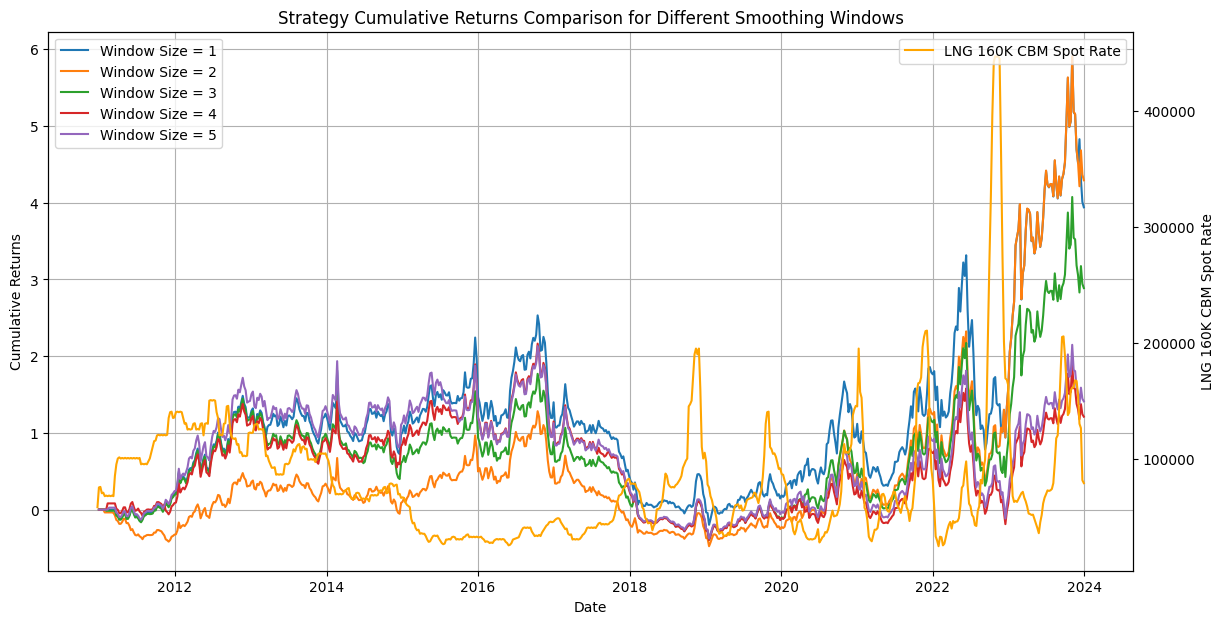

  Total Return Annualized Return Sharpe Ratio Max Drawdown
1      3.93965          0.807489     0.856796     -0.37973
2     4.291911          0.854224     0.906001     -0.37973
3     2.886703          0.653834     0.693452     -0.37973
4     1.211124          0.341867     0.361821     -0.37973
5     1.411139          0.385629     0.408683     -0.37973


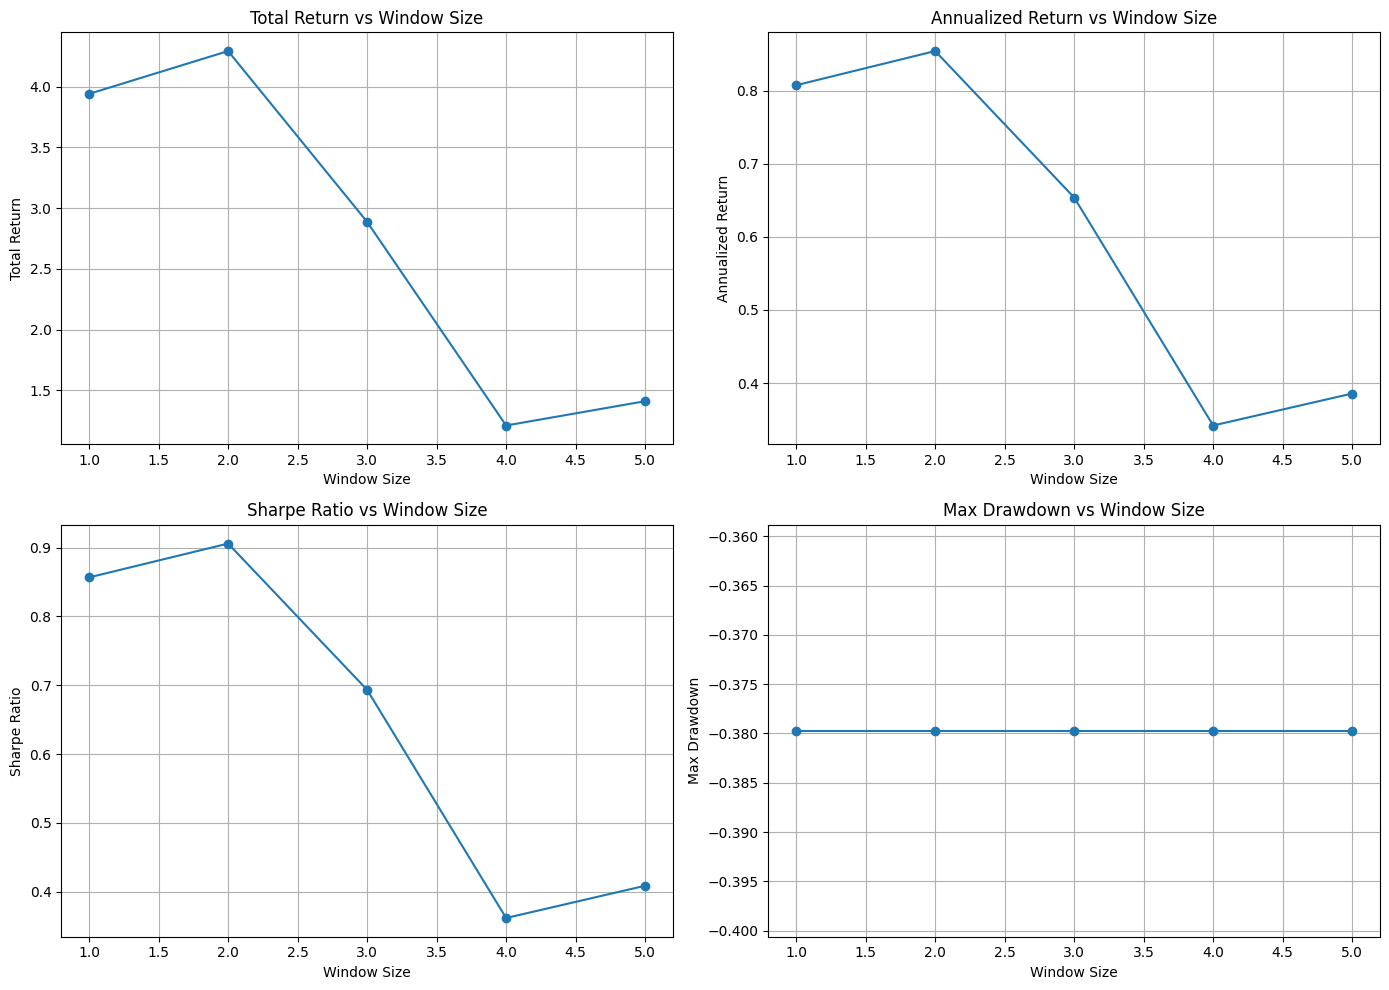

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('E:/jupyter/LNG/quant_simple.csv', parse_dates=['Date'])

# 处理数据格式，将逗号去掉并转换为浮点数
data['LNG 160K CBM Spot Rate'] = data['LNG 160K CBM Spot Rate'].str.replace(',', '').astype(float)

# 将日期列转换为日期时间格式，并设置为索引
data.set_index('Date', inplace=True)

# 定义市场状态
def define_market_state(data, window=4):
    data['LNG Rate Change'] = data['LNG 160K CBM Spot Rate Smoothed'].pct_change().fillna(0)
    data['LNG MA'] = data['LNG 160K CBM Spot Rate Smoothed'].rolling(window=window, min_periods=1).mean()
    data['Market State'] = np.where(data['LNG Rate Change'] > 0, 'up', 'down')
    
    # 检测波峰
    data['Peak'] = (data['LNG 160K CBM Spot Rate Smoothed'] == data['LNG 160K CBM Spot Rate Smoothed'].rolling(window=window, center=True).max())
    data['Peak'] = data['Peak'].shift().fillna(False)
    data['Post-Peak'] = (data['Peak'].shift() & (data['Market State'] == 'down')).fillna(False)
    
    return data

# MACD策略
def macd_strategy(data, short_window=12, long_window=26, signal_window=9):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    short_ema = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].ewm(span=short_window, min_periods=1).mean()
    long_ema = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, min_periods=1).mean()
    signals['signal'][short_window:] = (macd[short_window:] > signal_line[short_window:]) * 1.0 + (macd[short_window:] < signal_line[short_window:]) * -1.0
    signals['positions'] = signals['signal'].diff()
    return signals

# 动量策略
def momentum_strategy(data, window=4):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    momentum = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].pct_change(periods=window)
    signals['signal'] = np.where(momentum > 0, 1.0, -1.0)
    signals['positions'] = signals['signal'].diff()
    return signals

# 综合策略
def combined_strategy(data):
    data = define_market_state(data)
    signals_macd = macd_strategy(data)
    signals_momentum = momentum_strategy(data)
    
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = np.where(data['Post-Peak'], signals_momentum['signal'], signals_macd['signal'])
    signals['positions'] = signals['signal'].diff()
    
    return signals

# 计算策略的累计收益率和其他指标
def calculate_performance(data, signals):
    positions = signals['signal'].shift()
    daily_returns = data['Weekly Natural Gas Futures Contract 1  (Dollars per Million Btu)'].pct_change()
    strategy_returns = positions * daily_returns

    # 累计收益率
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    
    # 总收益率
    total_return = cumulative_returns.iloc[-1]
    
    # 年化收益率
    annualized_return = (1 + total_return)**(252/len(cumulative_returns)) - 1
    
    # 年化波动率
    annualized_volatility = strategy_returns.std() * np.sqrt(252)
    
    # 夏普比率
    sharpe_ratio = annualized_return / annualized_volatility
    
    # 最大回撤
    rolling_max = (1 + strategy_returns).cummax()
    daily_drawdown = (1 + strategy_returns)/rolling_max - 1
    max_drawdown = daily_drawdown.min()
    
    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Cumulative Returns': cumulative_returns
    }

# 测试不同平滑窗口大小下的策略表现
window_sizes = [1, 2, 3, 4, 5]
strategy_performance_by_window = {}

for window in window_sizes:
    data['LNG 160K CBM Spot Rate Smoothed'] = data['LNG 160K CBM Spot Rate'].rolling(window=window, min_periods=1).mean()
    signals = combined_strategy(data)
    performance = calculate_performance(data, signals)
    strategy_performance_by_window[window] = performance

# 绘制不同平滑窗口大小下策略的累计收益率比较
fig, ax1 = plt.subplots(figsize=(14, 7))

for window in window_sizes:
    ax1.plot(strategy_performance_by_window[window]['Cumulative Returns'], label=f'Window Size = {window}')

ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax1.set_title('Strategy Cumulative Returns Comparison for Different Smoothing Windows')
ax1.legend(loc='upper left')
ax1.grid(True)

# 创建次坐标轴并绘制LNG 160K CBM Spot Rate
ax2 = ax1.twinx()
ax2.plot(data['LNG 160K CBM Spot Rate'], color='orange', label='LNG 160K CBM Spot Rate')
ax2.set_ylabel('LNG 160K CBM Spot Rate')
ax2.legend(loc='upper right')
ax2.grid(False)

plt.show()

# 输出每个窗口大小下每个策略的性能指标
performance_df = pd.DataFrame(strategy_performance_by_window).T
performance_df = performance_df[['Total Return', 'Annualized Return', 'Sharpe Ratio', 'Max Drawdown']]
print(performance_df)

# 绘制性能指标随着窗口大小的变化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
performance_metrics = ['Total Return', 'Annualized Return', 'Sharpe Ratio', 'Max Drawdown']

for i, metric in enumerate(performance_metrics):
    ax = axes[i//2, i%2]
    ax.plot(window_sizes, performance_df[metric], marker='o')
    ax.set_title(f'{metric} vs Window Size')
    ax.set_xlabel('Window Size')
    ax.set_ylabel(metric)
    ax.grid(True)

plt.tight_layout()
plt.show()
